# Distribution of Payments to JP Morgan
- Normal-assumption simulation

       YT     BT  alpha  payment
0  109.91  24.65   0.25    38.11
1  105.86  32.89  -1.07   107.88
2  127.77  24.95   0.23    39.12
3   83.30  28.06  -0.39    71.96
4  133.33  29.14  -0.47    76.50
5  133.41  24.03   0.47    26.40
6  116.53  15.94   1.00    -1.59
7  164.21  24.90   0.45    27.36
8  146.64  28.57  -0.30    67.42
9  144.47  19.72   1.16    -9.83


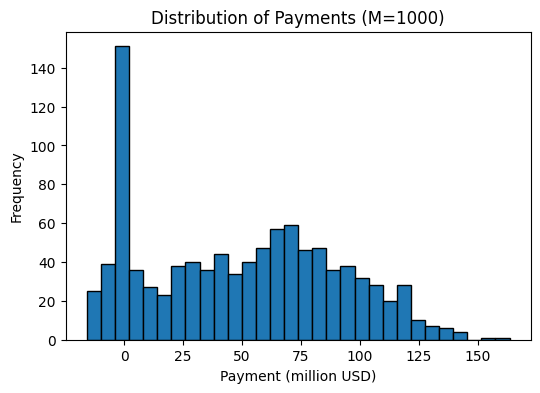

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# ----- 가정 (슬라이드) -----
Y0, B0 = 122.0, 25.884                # means (muY, muB)
stdY, stdB = Y0*0.20, B0*0.20          # std = mean * 20%
rho = 0.20                             # corr(YT, BT)
M = 1000                               # number of simulations (슬라이드와 동일)
seed = 42                               # 재현용

# 지급식 파라미터
notional = 53.0        # $53M
base_rate = 0.03       # 3%
m = 5                # 바트 항 multiplier (원식). PV표처럼 하려면 5.0으로 바꿔도 됨.
rD = 0.03; T = 1.0     # PV 계산용(원하면 사용)

rng = np.random.RandomState(seed)

# ----- (YT, BT) ~ 다변량 정규 -----
mean = np.array([Y0, B0])
cov = np.array([[stdY**2,           rho*stdY*stdB],
                [rho*stdY*stdB,     stdB**2     ]])

samples = rng.multivariate_normal(mean, cov, size=M)
YT = samples[:, 0]
BT = samples[:, 1]

# ----- alpha, payment -----
yen_term  = np.maximum(0.0, (YT - Y0) / YT)
baht_term = np.minimum(1.0,  m * (B0 - BT) / BT)
alpha = yen_term + baht_term

payment = notional * (1 - base_rate - alpha)     # (at T, million USD)
pv0 = payment * math.exp(-rD*T)                  # (optional) present value

# ----- 테이블/히스토그램 (슬라이드 스타일) -----
df = pd.DataFrame({"YT": YT, "BT": BT, "alpha": alpha, "payment": payment})
print(df.head(10).round(2).to_string(index=True))

plt.figure(figsize=(6,4))
plt.hist(payment, bins=30, edgecolor="black")
plt.title("Distribution of Payments (M=1000)")
plt.xlabel("Payment (million USD)")
plt.ylabel("Frequency")
plt.show()

# GBM-inverse FX Monte Carlo — PV Tables (RandomState version)
- 난수 발생기: np.random.RandomState (Mersenne Twister)
- seed = 42, M = 100,000

In [35]:
import numpy as np
import pandas as pd
import math

# ---------------- 기본 파라미터 ----------------
Y0 = 122.0        # JPY per USD (초기)
B0 = 25.884       # THB per USD (초기)
T  = 1.0          # (년)

rD = 0.03         # USD 할인율
rY = 0.01         # JPY 금리
rB = 0.13         # THB 금리

rho = 0.20        # corr(엔, 바트)
notional  = 53.0  # $53M
base_rate = 0.03  # 3%
M = 100_000       # 시뮬레이션 횟수
seed = 42

# σY, σB 그리드
sigmaY_list = [0.01, 0.05, 0.10, 0.20, 0.30, 0.50]
sigmaB_list = [0.01, 0.05, 0.10, 0.20, 0.30, 0.50, 0.60]

# multiplier 민감도
mult_list = [3.0, 4.0, 5.0, 6.0]

In [36]:
# --------------- RNG/노이즈 ---------------
def make_rng(seed):
    return np.random.RandomState(seed)

def draw_correlated_normals(n, rho, rng):
    z1 = rng.standard_normal(n)
    z2 = rng.standard_normal(n)
    eps1 = z1
    eps2 = rho*z1 + np.sqrt(max(0.0, 1 - rho**2))*z2
    return eps1, eps2

In [37]:
# --------------- 핵심 시뮬레이션 ---------------
def simulate_payments_gbm_inverse(sigmaY, sigmaB, m, M, seed):
    rng = make_rng(seed)
    eps1, eps2 = draw_correlated_normals(M, rho, rng)

    # 1/Y, 1/B GBM
    invYT = (1.0 / Y0) * np.exp((rD - rY - 0.5*sigmaY**2)*T + sigmaY*eps1*np.sqrt(T))
    invBT = (1.0 / B0) * np.exp((rD - rB - 0.5*sigmaB**2)*T + sigmaB*eps2*np.sqrt(T))
    YT = 1.0 / invYT
    BT = 1.0 / invBT

    # alpha, 지급액, 현재가치
    yen_term  = np.maximum(0.0, (YT - Y0) / YT)
    baht_term = np.minimum(1.0, m * (B0 - BT) / BT)
    alpha = yen_term + baht_term
    payment_T = notional * (1 - base_rate - alpha)
    pv0 = payment_T * math.exp(-rD*T)

    return float(np.mean(pv0))

In [38]:
# --------------- 표 1: PV 그리드(σY×σB) ---------------
def pv_grid_sigma(multiplier=5.0):
    table = []
    for sy in sigmaY_list:
        row = []
        for sb in sigmaB_list:
            pv = simulate_payments_gbm_inverse(sy, sb, multiplier, M, seed)
            row.append(round(pv, 2))
        table.append(row)

    df = pd.DataFrame(
        table,
        index=pd.Index([f"{sy:.2f}" for sy in sigmaY_list], name="sigmaY"),
        columns=pd.Index([f"{sb:.2f}" for sb in sigmaB_list], name="sigmaB"),
    )
    return df


In [39]:
# --------------- 표 2: PV vs multiplier ---------------
def pv_vs_multiplier(sy=0.10, sb=0.10):
    out = []
    for m in mult_list:
        pv = simulate_payments_gbm_inverse(sy, sb, m, M, seed)
        out.append((m, round(pv, 2)))
    return pd.DataFrame(out, columns=["multiplier", "PV"])


In [40]:
# --------------- 실행 ---------------
if __name__ == "__main__":
    grid_df = pv_grid_sigma(multiplier=5.0)   # σY×σB 그리드, multiplier=5
    mult_df = pv_vs_multiplier(0.10, 0.10)   # σY=σB=0.10에서 multiplier 민감도

    print("=== Present Value Grid (σY × σB, multiplier=5, ρ=0.20, M=100k, seed=0) ===")
    print(grid_df.to_string())

    print("\n=== PV vs Multiplier (σY=0.10, σB=0.10, ρ=0.20, M=100k, seed=0) ===")
    print(mult_df.to_string(index=False))

=== Present Value Grid (σY × σB, multiplier=5, ρ=0.20, M=100k, seed=0) ===
sigmaB   0.01   0.05   0.10   0.20   0.30   0.50    0.60
sigmaY                                                  
0.01    74.36  74.35  74.35  76.20  81.70  97.77  106.76
0.05    73.76  73.75  73.75  75.61  81.11  97.17  106.16
0.10    72.77  72.76  72.76  74.61  80.11  96.18  105.17
0.20    70.72  70.71  70.71  72.57  78.07  94.13  103.12
0.30    68.67  68.66  68.67  70.52  76.02  92.08  101.07
0.50    64.62  64.61  64.61  66.46  71.96  88.03   97.02

=== PV vs Multiplier (σY=0.10, σB=0.10, ρ=0.20, M=100k, seed=0) ===
 multiplier    PV
        3.0 62.96
        4.0 67.86
        5.0 72.76
        6.0 77.68
